In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5','0.4','0.3','0.2','0.1']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/nulln/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    elif gamma == '0.4':
        return '40'
    elif gamma == '0.3':
        return '30'
    elif gamma == '0.2':
        return '20'
    elif gamma == '0.1':
        return '10'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    elif gamma == '0.4':
        return 6
    elif gamma == '0.3':
        return 7
    elif gamma == '0.2':
        return 8
    elif gamma == '0.1':
        return 9
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [7]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java --enable-preview -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
        print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_nulln", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+\.\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [8]:
results = run_expm1() 

java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 1 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 2 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 3 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 1 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 2 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 3 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 1 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 2 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 3 -o ./output_expm1/nulln/
java -jar ./SketchingTweet-v1_nulln.jar -iu 1000 -qu 1000 -p 0.7 -s 0.5 -n 1 -o ./

# Process Results

In [9]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [10]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%,Summary_40%,Summary_30%,Summary_20%,Summary_10%
Run,1,1,1,1,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%,40.0%,30.0%,20.0%,10.0%
Index time unit,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610,197610,197610,197610,197610
Index size,215201,194041,172915,151563,130102,108819,87460,65846,43880,22137


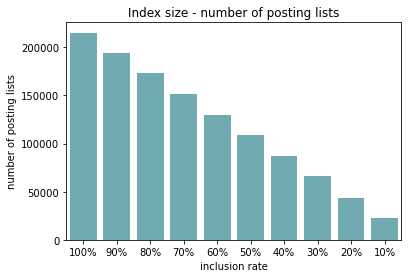

Summary_100%    215201
Summary_90%     194041
Summary_80%     172915
Summary_70%     151563
Summary_60%     130102
Summary_50%     108819
Summary_40%      87460
Summary_30%      65846
Summary_20%      43880
Summary_10%      22137
Name: Index size, dtype: object

In [11]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

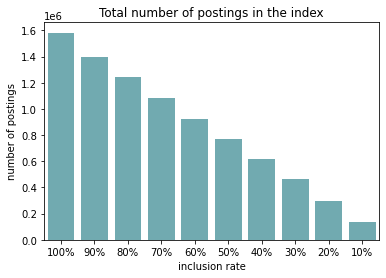

Total number of postings:


[1582263,
 1400449,
 1247055,
 1084939,
 924049,
 767564,
 615504,
 463374,
 294224,
 137552]

In [12]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

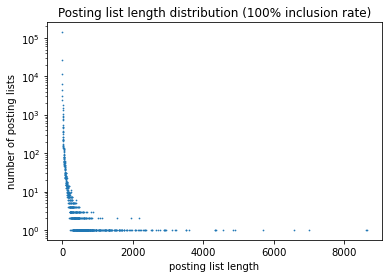

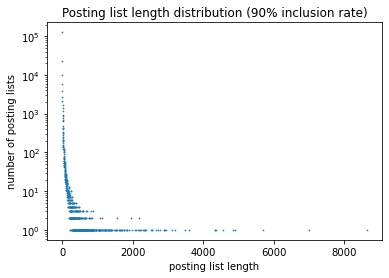

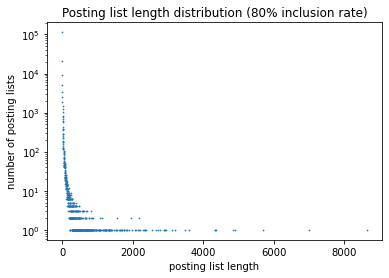

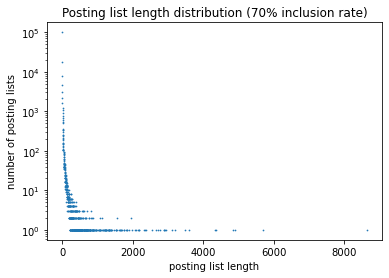

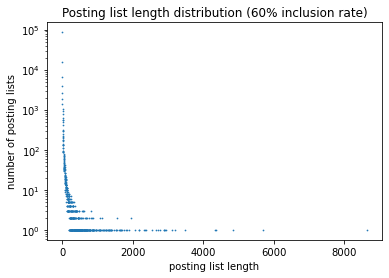

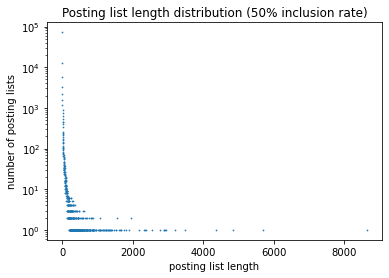

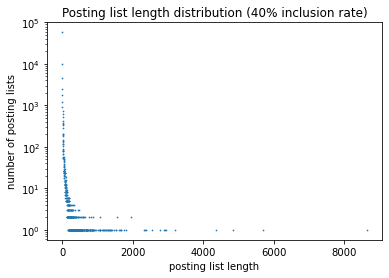

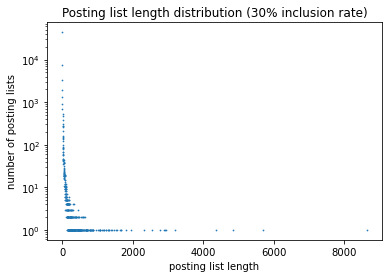

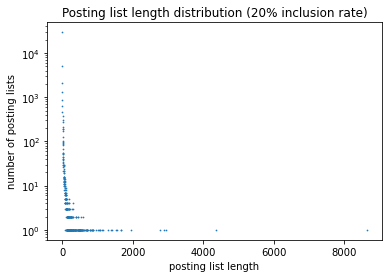

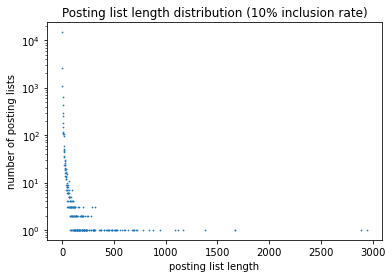

In [13]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.352489068359348, 7.217283976066914, 7.211953850157592, 7.158336797239432, 7.102496502744001, 7.0535843924314685, 7.037548593642808, 7.037238404762628, 6.7051959890610755, 6.213669422234268]


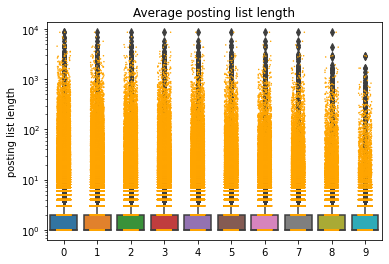

In [14]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [15]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,189567,189567,189567,189567,189567,189567,189567,197168,197168,-1,...,5137,4670,4670,3416,1440,640,640,2,2,-1
1,146028,146028,146028,146028,197559,191639,191639,191639,191639,-1,...,6516,4336,4336,3243,2,1,1,1,1,-1
2,-1,-1,-1,145908,145908,145908,145908,145908,145908,191141,...,-1,-1,-1,1608,1320,184,184,184,180,1
3,-1,-1,-1,-1,-1,185838,185838,185838,185838,-1,...,-1,-1,-1,-1,-1,2,1,1,1,-1
4,-1,-1,-1,-1,-1,157608,157608,157608,157608,157608,...,-1,-1,-1,-1,-1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,196841,196841,196654,196654,-1,-1,...,-1,-1,-1,-1,2,2,1,1,-1,-1
21886,-1,-1,-1,-1,-1,-1,-1,-1,-1,197232,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
21887,-1,-1,-1,-1,-1,197608,197608,197608,197608,197608,...,-1,-1,-1,-1,-1,2,2,2,2,2
21888,-1,-1,-1,-1,-1,195394,195394,193415,197458,-1,...,-1,-1,-1,-1,-1,324,324,408,2,-1


In [17]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,189567,189567,189567,189567,189567,189567,189567,197168,197168,-1,...,5137,4670,4670,3416,1440,640,640,2,2,-1
1,146028,146028,146028,146028,197559,191639,191639,191639,191639,-1,...,6516,4336,4336,3243,2,1,1,1,1,-1
8,44802,44802,197071,197071,197071,197071,197071,197606,-1,-1,...,38975,38975,60,60,60,42,42,2,-1,-1
12,170152,193999,193999,197505,197505,197505,197479,197479,197479,-1,...,7605,364,364,2,2,2,1,1,1,-1
15,102434,102434,187662,187662,187662,187662,187662,197389,197389,197389,...,10200,10200,328,219,219,219,219,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,7,7,6,6,5,4,4,4,4,1
21880,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,7,7,6,6,5,4,4,4,4,1
21881,93654,93654,93654,93654,93654,93654,93654,93654,101002,155558,...,81484,81315,81315,81315,56500,56500,30888,20526,1344,1
21884,178680,178680,178680,178680,178680,178680,178680,178680,-1,145535,...,120,84,84,66,66,66,30,16,-1,1


In [18]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7247, 5435, 4477, 3744, 2967, 2227, 1711, 1135, 685, 323]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 75.0% truly similar tweets
Using 80% of terms, we can find 61.78% truly similar tweets
Using 70% of terms, we can find 51.66% truly similar tweets
Using 60% of terms, we can find 40.94% truly similar tweets
Using 50% of terms, we can find 30.73% truly similar tweets
Using 40% of terms, we can find 23.61% truly similar tweets
Using 30% of terms, we can find 15.66% truly similar tweets
Using 20% of terms, we can find 9.45% truly similar tweets
Using 10% of terms, we can find 4.46% truly similar tweets


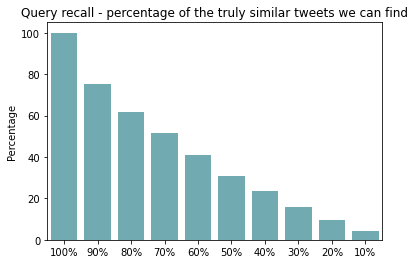

In [19]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [20]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7247, 8370, 9507, 10853, 12518, 14012, 15432, 16190, 14966, 10029]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 64.93% tweets that we found similar are truly similar tweets
Using 80% of terms, 47.09% tweets that we found similar are truly similar tweets
Using 70% of terms, 34.5% tweets that we found similar are truly similar tweets
Using 60% of terms, 23.7% tweets that we found similar are truly similar tweets
Using 50% of terms, 15.89% tweets that we found similar are truly similar tweets
Using 40% of terms, 11.09% tweets that we found similar are truly similar tweets
Using 30% of terms, 7.01% tweets that we found similar are truly similar tweets
Using 20% of terms, 4.58% tweets that we found similar are truly similar tweets
Using 10% of terms, 3.22% tweets that we found similar are truly similar tweets


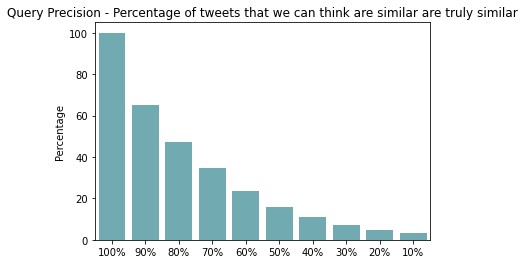

In [21]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [22]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
96,197172,7303,197172,197172,197172,197172,197172,197172,197172,197172,...,156,6840,21,6,6,5,4,3,3,1
151,197528,197528,197528,197528,197528,197528,197528,197528,197528,197528,...,12,10,10,4,4,4,3,2,2,1
185,197528,197528,197528,197528,197528,197528,197528,197528,197528,197528,...,6,4,4,4,3,3,2,2,2,1
216,176547,176547,176547,176547,176547,176547,176547,176547,176547,176547,...,2920,2920,2920,2331,2331,2331,2331,1914,1595,951
252,189994,189994,189994,189994,189994,189994,190851,190851,190851,189994,...,40,6,6,6,6,6,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21827,197528,197528,197528,197528,197528,197528,197528,197528,197528,197528,...,6,4,4,4,3,3,2,2,2,1
21860,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,7,7,6,6,5,4,4,4,4,1
21875,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,7,7,6,6,5,4,4,4,4,1
21878,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,7,7,6,6,5,4,4,4,4,1


In [23]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 2799, 3289, 3267, 2782, 2173, 1692, 1130, 685, 323]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 51.5% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 73.46% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 87.26% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 93.76% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 97.58% queries need less lookups before correctly finding the true similar tweets
Using 40% of terms, 98.89% queries need less lookups before correctly finding the true similar tweets
Using 30% of terms, 99.56% queries need less lookups before correctly finding the true similar tweets
Using 20% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 10% of terms, 100.0% queries need less lookups before correctly finding the tr

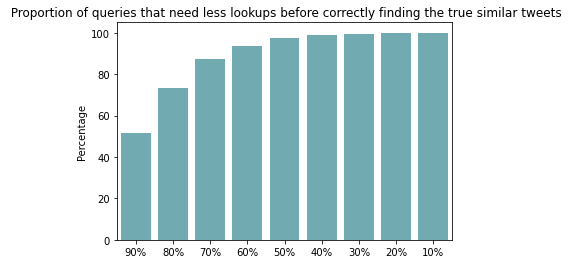

In [24]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

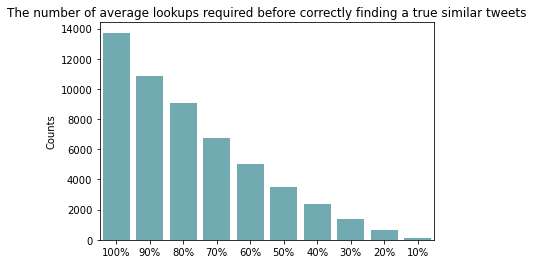

In [25]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [26]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 21.14% of less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 34.12% of less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 50.67% of less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 63.61% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 74.69% of less lookups are needed for correctly finding a true similar tweets
By using 40% of terms, 82.94% of less lookups are needed for correctly finding a true similar tweets
By using 30% of terms, 89.89% of less lookups are needed for correctly finding a true similar tweets
By using 20% of terms, 95.42% of less lookups are needed for correctly finding a true similar tweets
By using 10% of terms, 99.32% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [27]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,...,Index_time_run3_40%,Index_time_run1_30%,Index_time_run2_30%,Index_time_run3_30%,Index_time_run1_20%,Index_time_run2_20%,Index_time_run3_20%,Index_time_run1_10%,Index_time_run2_10%,Index_time_run3_10%
0,11.0675,12.5781,13.0955,17.3633,16.8009,19.3073,16.5710,21.8004,21.1846,16.9504,...,14.0507,15.6379,16.4679,14.8967,17.7480,20.9292,18.7780,14.9072,18.2641,13.5509
1,5.3119,5.3248,5.3961,9.0368,8.1421,10.5064,6.5859,7.4080,8.0951,6.8193,...,6.3504,7.7762,5.8003,5.8325,6.0890,7.8622,5.7035,5.6826,7.5216,5.3954
2,5.0343,5.1701,5.7601,8.1747,8.0483,9.1358,6.5034,8.1615,6.3331,7.5636,...,5.9169,7.4538,5.2964,5.8078,6.2286,7.8334,5.3285,4.6134,8.2315,6.6637
3,4.5800,6.6241,7.5436,6.2077,6.8398,8.5016,6.7729,6.7313,6.4674,5.5311,...,5.6330,6.5916,6.4109,5.0681,5.5532,7.0276,5.0105,4.3225,5.9787,5.7867
4,4.7306,5.1529,7.2644,6.5612,6.7511,7.9302,6.9594,6.5532,6.6474,6.3418,...,5.4896,6.3675,5.9033,6.5551,5.5683,6.6352,5.1088,4.5159,6.6194,6.7822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.4623,2.6277,14.3005,3.7057,3.8572,3.5111,2.9843,3.6266,4.5225,3.9111,...,3.3980,2.5763,2.4834,3.0802,3.0716,3.1690,2.9521,2.7325,2.7430,2.8866
193,2.6879,2.7023,2.3575,4.1003,3.8004,3.4973,2.9447,3.6823,3.7663,3.5219,...,3.6985,2.6043,2.3451,2.8702,3.4620,2.8219,2.9862,2.7131,2.6872,2.9184
194,2.7095,2.7994,2.0487,3.6025,4.0818,3.7644,2.9773,4.0826,5.4053,3.5793,...,3.2038,2.5641,2.5148,2.9125,3.2928,2.7741,2.9686,2.9124,2.7805,2.9599
195,2.5270,2.6205,1.9092,3.4826,3.6738,3.3322,2.8976,3.6280,3.4853,3.4121,...,3.1333,2.4758,2.4944,2.7915,3.9129,2.6538,2.8454,2.6095,2.5922,2.8838


By using 100% of terms, the average time for indexing 1000 tweets is 3.1441 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 4.3823 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 4.2134 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 3.9786 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 3.6669 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 3.7229 milliseconds
By using 40% of terms, the average time for indexing 1000 tweets is 3.6345 milliseconds
By using 30% of terms, the average time for indexing 1000 tweets is 3.245 milliseconds
By using 20% of terms, the average time for indexing 1000 tweets is 3.1902 milliseconds
By using 10% of terms, the average time for indexing 1000 tweets is 2.8977 milliseconds


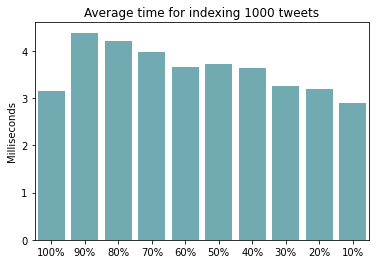

In [28]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [29]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,...,Query_time_run3_40%,Query_time_run1_30%,Query_time_run2_30%,Query_time_run3_30%,Query_time_run1_20%,Query_time_run2_20%,Query_time_run3_20%,Query_time_run1_10%,Query_time_run2_10%,Query_time_run3_10%
0,2.3636,3.9461,2.0884,2.0268,3.2877,2.4808,2.1547,2.4378,2.2440,2.7540,...,1.9902,2.5230,2.0381,1.2981,2.1066,1.2015,2.6196,0.1950,0.2210,0.1957
1,360.5058,310.2517,291.4695,291.6378,265.1349,268.3626,222.3331,229.1662,211.3277,200.1668,...,130.4444,77.5098,91.7451,75.3828,38.9078,33.2077,32.8982,17.1089,18.5873,16.6061
2,228.7650,183.2790,195.4371,156.4170,166.0487,156.6454,120.4659,113.2250,112.2268,93.4450,...,33.1717,49.0653,45.9990,51.1551,25.2152,21.1370,19.9162,10.0748,9.0409,9.7487
3,237.6468,192.6269,201.1880,168.9091,177.8745,171.9857,128.8975,122.7974,120.7688,92.5841,...,31.5792,29.3248,16.4856,22.2329,26.5539,19.9660,18.7012,7.3228,6.6100,7.1527
4,252.8090,196.2534,213.1208,167.7500,173.3547,166.4782,121.9142,119.4421,116.0521,90.6666,...,28.4061,11.3071,17.2163,25.1930,19.1192,16.1864,14.8873,4.7066,4.2390,5.1733
5,288.1805,187.5412,198.1687,165.3544,159.9661,160.7939,120.4437,118.5845,109.4473,89.7782,...,32.6970,11.4295,15.9190,10.7368,21.1150,19.0315,22.4356,5.3612,5.0392,5.7646
6,266.2941,184.1199,201.9367,163.3327,162.9048,157.6895,116.5524,117.1541,115.0319,87.9235,...,28.5672,11.0262,13.8535,11.3750,23.4355,21.6169,19.8464,4.5867,4.4084,4.6480
7,196.8144,186.2092,207.3463,170.3006,164.2973,187.8708,129.3155,122.8847,117.3090,93.2362,...,35.0901,13.1964,15.3855,12.6345,23.4381,24.5771,23.6464,4.7816,4.8551,5.0581
8,195.6976,181.4599,195.9372,164.1339,157.3253,168.1838,120.7821,113.5846,113.9390,94.3425,...,35.7925,12.4350,28.9218,12.1820,20.8504,25.7750,21.2296,4.5219,4.7553,4.7908
9,234.6890,171.1844,181.1072,175.3942,150.4550,156.6607,111.3624,104.9767,102.9724,85.9306,...,38.5153,11.2203,11.1013,11.1651,19.4500,18.4470,19.3337,4.3081,4.0584,4.1795


By using 100% of terms, the average time for querying 1000 tweets is 186.5279 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 160.2005 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 111.7452 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 83.338 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 56.4899 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 40.708 milliseconds
By using 40% of terms, the average time for querying 1000 tweets is 32.8657 milliseconds
By using 30% of terms, the average time for querying 1000 tweets is 16.8911 milliseconds
By using 20% of terms, the average time for querying 1000 tweets is 16.9764 milliseconds
By using 10% of terms, the average time for querying 1000 tweets is 5.0532 milliseconds


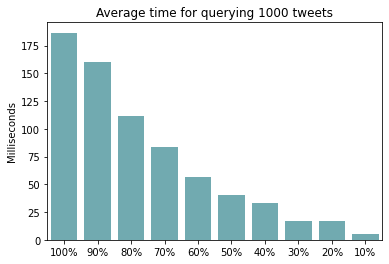

In [30]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))